**Task 1:** Data splitting and classification

Perform a train-val-test split of the data, and use a manual seed so that you and us can reproduce the same split your experiments. Split the 17034 images into 3k for testing, 2k for validation and the remainder for training. Split every class separately (stratified splitting).

In [2]:
import os
import copy
import shutil
import pickle
import tarfile
import zipfile
import datetime
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from tabulate import tabulate
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, classification_report
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

In [3]:
# Set the random seed for reproducibility
np.random.seed(42)

# Set the project folder
project_folder = '/content/drive/My Drive/IN4310/'
mount_point = '/content/drive'

# Define dataset paths
dataset_paths = {
    'buildings': 'data/buildings/',
    'forest': 'data/forest/',
    'glacier': 'data/glacier/',
    'mountain': 'data/mountain/',
    'sea': 'data/sea/',
    'street': 'data/street/',
}

In [4]:
# Unzip files into a temporary Google Colab folder to improve IO efficiency

# Delete existing data folders if they exist
if os.path.exists('/content/data'):
    shutil.rmtree('/content/data')
if os.path.exists('/content/mandatory1_data'):
    shutil.rmtree('/content/mandatory1_data')

# Unzip files into a temporary Google Colab folder to improve IO efficiency
if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point, project_folder))

src_file = 'mandatory1_data.zip'
dst_folder = '/content/data'

# Create the destination folder if it doesn't exist
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# Download the zip file
with tqdm(total=os.path.getsize(src_file), desc="Downloading", unit="B", unit_scale=True) as pbar:
    with open(src_file, "rb") as src, open('/content/mandatory1_data.zip', "wb") as dst:
        for chunk in iter(lambda: src.read(1024 * 1024), b""):
            dst.write(chunk)
            pbar.update(len(chunk))

# Extract the zip file
with zipfile.ZipFile('/content/mandatory1_data.zip', 'r') as zip_ref:
    with tqdm(total=len(zip_ref.infolist()), desc="Extracting.....", unit="file") as pbar:
        for member in zip_ref.infolist():
            zip_ref.extract(member, '/content/')
            pbar.update(1)

# Rename the extracted folder from mandatory1_data to data
if os.path.exists('/content/mandatory1_data'):
    os.rename('/content/mandatory1_data', dst_folder)

if os.path.exists('/content/mandatory1_data.zip'):
    os.remove('/content/mandatory1_data.zip')
    
print("Files extracted successfully.")

os.chdir('/content/')

if not os.path.exists(dst_folder):
    num_files = 0
else:
    num_files = 0
    for root, dirs, files in os.walk(dst_folder):
        num_files += len(files)

print(f'\nThere are {num_files} files in the destination folder: {dst_folder}')

Mounted at /content/drive


Downloading:   0%|          | 0.00/254M [00:00<?, ?B/s]

Extracting.....:   0%|          | 0/17041 [00:00<?, ?file/s]

Files extracted successfully.

There are 17034 files in the destination folder: /content/data


In [5]:
src_file_cifar = 'cifar-10-python.tar.gz'
src_url_cifar = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
dst_folder = '/content/data'

#shutil.rmtree('/content/data/cifar-10')
#shutil.rmtree('/content/data/cifar-10-batches-py')

# Create the destination folder if it doesn't exist
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# Download the tar.gz file
def download_progress_hook(count, block_size, total_size):
    global pbar
    pbar.update(block_size)

with tqdm(total=None, desc="Downloading", unit="B", unit_scale=True) as pbar:
    urllib.request.urlretrieve(src_url_cifar, filename=src_file_cifar, reporthook=download_progress_hook)

# Extract the tar.gz file
with tarfile.open(src_file_cifar, 'r:gz') as tar_ref:
    with tqdm(total=len(tar_ref.getmembers()), desc="Extracting", unit="file") as pbar:
        for member in tar_ref.getmembers():
            tar_ref.extract(member, dst_folder)
            pbar.update(1)

# Rename the extracted folder from cifar-10-batches-py to cifar-10
if os.path.exists(os.path.join(dst_folder, 'cifar-10-batches-py')):
    os.rename(os.path.join(dst_folder, 'cifar-10-batches-py'), os.path.join(dst_folder, 'cifar-10'))

# Remove the downloaded tar.gz file
if os.path.exists(src_file_cifar):
    os.remove(src_file_cifar)

print("CIFAR-10 dataset downloaded and extracted successfully.")

Downloading: 0.00B [00:00, ?B/s]

Extracting:   0%|          | 0/9 [00:00<?, ?file/s]

CIFAR-10 dataset downloaded and extracted successfully.


In [6]:
# Load data and create stratified train, val, and test sets
data = []
labels = []

num_images_per_class = 2500

for i, class_name in enumerate(dataset_paths):
    class_files = os.listdir(dataset_paths[class_name])
    selected_files = np.random.choice(class_files, num_images_per_class, replace=False)

    for file in selected_files:
        data.append(os.path.join(dataset_paths[class_name], file))
        labels.append(i)

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1, random_state=42, stratify=labels) # 10% images for test
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels) # 18% images for validation

Verify that obtained splits are disjoint

In [7]:
# Verify the splits are disjoint
def verify_dj(train_data, val_data, test_data):
    all_data = np.concatenate((train_data, val_data, test_data))
    unique_data = set(all_data)

    if len(unique_data) == len(all_data):
        print("The splits are disjoint")
    else:
        print("There are common elements between the splits")

# Call the function to verify the splits
verify_dj(train_data, val_data, test_data)

The splits are disjoint


In [8]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'visualization': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

Dataloaders for the train, validation and test dataset parts

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path, label = self.file_list[index]  # Get the img_path and label directly from the file_list
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, os.path.basename(img_path)

In [10]:
# Create dataset instances for train, val, and test sets (v2)

train_dataset = Dataset([(train_data[i], train_labels[i]) for i in range(len(train_data))], transform=data_transforms['train'])
val_dataset = Dataset([(val_data[i], val_labels[i]) for i in range(len(val_data))], transform=data_transforms['valid'])
test_dataset = Dataset([(test_data[i], test_labels[i]) for i in range(len(test_data))], transform=data_transforms['test'])

num_workers = 0
batch_size = 64

# Create dataloaders for train, val, and test sets
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'valid': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

Choose a neural network of your likes, train using finetuning

In [11]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
# Initialize dictionaries to store losses and accuracies for each hyperparameter
all_train_losses = {}
all_train_accuracies = {}
all_val_losses = {}
all_val_accuracies = {}

def train_and_evaluate(learning_rates, optimizers, epochs, best_val_acc, best_model_params):

    best_model = None
    
    for opt in optimizers:

        for lr in learning_rates:

            #hp = f'{lr}_{opt}'
            print(f'\n\n\nTraining with learning rate: {lr} and optimizer: {opt}\n\n')

            # Create a new model for each hyperparameter combination
            class_names = list(dataset_paths.keys())

            # Create the model
            model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            num_features = model.fc.in_features
            model.fc = nn.Linear(num_features, len(class_names))
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()

            # Initialize the optimizer based on the selected type
            if opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)

            # Training and validation v2 (with progress monitoring and plots)

            # Initialize lists to store loss and accuracy values
            train_losses = []
            train_accuracies = []
            val_losses = []
            val_accuracies = []

            # Training and validation
            num_epochs = epochs

            for epoch in range(num_epochs):
                print(f'\nEpoch {epoch + 1}/{num_epochs}')
                print('-' * 10)

                hp = f'{lr}_{opt}_{epoch}'

                for phase in ['train', 'valid']:
                    if phase == 'train':
                        model.train()
                    else:
                        model.eval()

                    running_loss = 0.0
                    running_corrects = 0
                    num_samples = 0
                    image_filenames = []

                    progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                    for inputs, labels, filenames in progress_bar:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        optimizer.zero_grad()

                        # Forward pass and calculate the loss
                        with torch.set_grad_enabled(phase == 'train'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            # Backward pass and optimize the weights
                            if phase == 'train':
                                loss.backward()
                                optimizer.step()

                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                        num_samples += inputs.size(0)
                        image_filenames.extend(filenames)  # Add the filenames to the list

                        # Update the progress bar
                        progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                    epoch_loss = running_loss / num_samples
                    epoch_acc = running_corrects.double() / num_samples

                    print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                    if phase == 'train':
                        train_losses.append(epoch_loss)
                        train_accuracies.append(epoch_acc)
                    else:
                        val_losses.append(epoch_loss)
                        val_accuracies.append(epoch_acc)


            # Save the losses and accuracies for the current setting
            all_train_losses[hp] = train_losses
            all_train_accuracies[hp] = train_accuracies
            all_val_losses[hp] = val_losses
            all_val_accuracies[hp] = val_accuracies

            current_val_acc = max(val_accuracies)
            max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1
            
            # Update the best model if the current validation accuracy is better
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_model = model
                best_model_params = {
                    'lr': lr,
                    'optimizer': opt,
                    'model_state': model.state_dict(),
                    'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy was achieved
                }

                table = [["Best Validation Accuracy", f"{best_val_acc:.4f}"],
                        ["Learning Rate", best_model_params["lr"]],
                        ["Optimizer", best_model_params["optimizer"]],
                        ["Epoch", best_model_params["val_acc_epoch"]]]

                print('\n\n', tabulate(table, tablefmt="simple"))
                
                if best_model is not None:
                    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
                    model_save_name = f'model__acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_images{num_images_per_class * 6}.pth'
                    model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                    torch.save(best_model_params['model_state'], model_save_path)
                    print(f'\nBest model saved to {model_save_path}')

                    # Save the best model as 'best_model.pth'
                    model_save_name = 'best_model.pth'
                    model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                    torch.save(best_model_params['model_state'],model_save_path)
                    print(f'\nBest model also saved as "best_model.pth"\n\n')

    # Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
    accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')
    if not os.path.exists(accuracy_folder):
        os.makedirs(accuracy_folder)

    # Save the dictionaries to files with hyperparameter information in the file names
    file_name_prefix = f'acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_images{num_images_per_class * 6}'

    with open(os.path.join(accuracy_folder, f"all_train_accuracies_{file_name_prefix}.pickle"), "wb") as handle:
        pickle.dump(all_train_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(accuracy_folder, f"all_val_accuracies_{file_name_prefix}.pickle"), "wb") as handle:
        pickle.dump(all_val_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return best_model

In [13]:
def plot_metrics():
    def convert_to_cpu(tensor_list):
        #return [tensor.cpu().numpy() for tensor in tensor_list]
        return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]

    all_train_accuracies_cpu = {k: convert_to_cpu(v) for k, v in all_train_accuracies.items()}
    all_val_accuracies_cpu = {k: convert_to_cpu(v) for k, v in all_val_accuracies.items()}
    all_train_losses_cpu = {k: convert_to_cpu(v) for k, v in all_train_losses.items()}
    all_val_losses_cpu = {k: convert_to_cpu(v) for k, v in all_val_losses.items()}

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    for setting, accuracies in all_val_accuracies_cpu.items():
        axs[0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)

    max_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_acc_epoch = all_val_accuracies_cpu[max_acc_setting].index(max_acc_value) + 1

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_title(f"Validation Accuracy (max: {max_acc_value * 100:.2f}% - {max_acc_setting})")
    axs[0].legend()

    for setting, losses in all_val_losses_cpu.items():
        axs[1].plot(range(1, len(losses) + 1), losses, label=setting)

    min_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_loss_epoch = all_val_losses_cpu[min_loss_setting].index(min_loss_value) + 1

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].set_title(f"Validation Loss (min: {min_loss_value:.4f} - {min_loss_setting})")
    axs[1].legend()

    plt.show()

In [ ]:
# Define the hyperparameters to search
learning_rates = [0.001, 0.01]
optimizers = ['Adam', 'SGD']
epochs = 25

best_val_acc = float('-inf')
best_model_params = None

train_and_evaluate(learning_rates, optimizers, epochs, best_val_acc, best_model_params)




Training with learning rate: 0.001 and optimizer: Adam



Epoch 1/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6503 accuracy: 76.44%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.5335 accuracy: 79.44%

Epoch 2/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4918 accuracy: 82.17%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3816 accuracy: 86.37%

Epoch 3/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4492 accuracy: 84.06%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3304 accuracy: 88.19%

Epoch 4/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4167 accuracy: 84.98%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2847 accuracy: 89.30%

Epoch 5/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.4112 accuracy: 84.91%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3232 accuracy: 88.44%

Epoch 6/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3851 accuracy: 86.30%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2937 accuracy: 89.44%

Epoch 7/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3830 accuracy: 86.34%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3303 accuracy: 88.30%

Epoch 8/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3578 accuracy: 86.94%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3397 accuracy: 87.19%

Epoch 9/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3563 accuracy: 86.58%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3520 accuracy: 87.00%

Epoch 10/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3462 accuracy: 87.30%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3444 accuracy: 87.59%

Epoch 11/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3269 accuracy: 88.01%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3071 accuracy: 88.52%

Epoch 12/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3415 accuracy: 87.69%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2409 accuracy: 91.07%

Epoch 13/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3243 accuracy: 88.05%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2666 accuracy: 90.59%

Epoch 14/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3290 accuracy: 88.14%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2941 accuracy: 89.52%

Epoch 15/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3198 accuracy: 88.34%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2700 accuracy: 90.78%

Epoch 16/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3076 accuracy: 88.83%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2493 accuracy: 91.78%

Epoch 17/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2944 accuracy: 89.23%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2858 accuracy: 90.44%

Epoch 18/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3081 accuracy: 88.58%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2714 accuracy: 91.04%

Epoch 19/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2921 accuracy: 89.20%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2501 accuracy: 91.52%

Epoch 20/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2892 accuracy: 89.33%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2568 accuracy: 91.04%

Epoch 21/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2828 accuracy: 89.83%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2567 accuracy: 91.56%

Epoch 22/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2876 accuracy: 89.24%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2565 accuracy: 91.89%

Epoch 23/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2858 accuracy: 89.36%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2653 accuracy: 90.70%

Epoch 24/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2689 accuracy: 90.37%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3104 accuracy: 89.11%

Epoch 25/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2628 accuracy: 90.14%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2509 accuracy: 91.26%


 ------------------------  ------
Best Validation Accuracy  0.9189
Learning Rate             0.001
Optimizer                 Adam
Epoch                     22
------------------------  ------

Best model saved to /content/drive/My Drive/IN4310/model__acc0.9189_lr0.001_Adam_epoch22_images15000.pth

Best model also saved as "best_model.pth"





Training with learning rate: 0.01 and optimizer: Adam



Epoch 1/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 1.5974 accuracy: 36.07%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 1.3631 accuracy: 44.89%

Epoch 2/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 1.1540 accuracy: 53.07%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.9879 accuracy: 61.74%

Epoch 3/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 1.0097 accuracy: 60.49%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.8515 accuracy: 68.22%

Epoch 4/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.8979 accuracy: 65.32%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.7643 accuracy: 70.37%

Epoch 5/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.8263 accuracy: 68.65%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.6023 accuracy: 77.96%

Epoch 6/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.8917 accuracy: 66.54%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 1.7108 accuracy: 61.19%

Epoch 7/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.8622 accuracy: 67.49%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.6568 accuracy: 75.78%

Epoch 8/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.7566 accuracy: 71.66%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.6339 accuracy: 76.48%

Epoch 9/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.7015 accuracy: 73.56%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.7142 accuracy: 75.48%

Epoch 10/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6789 accuracy: 74.56%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.5482 accuracy: 79.22%

Epoch 11/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6486 accuracy: 76.26%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.6062 accuracy: 78.22%

Epoch 12/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6227 accuracy: 77.06%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.5270 accuracy: 79.93%

Epoch 13/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6146 accuracy: 77.19%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.5489 accuracy: 78.52%

Epoch 14/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6173 accuracy: 77.73%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4838 accuracy: 82.74%

Epoch 15/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5914 accuracy: 78.46%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.5291 accuracy: 80.22%

Epoch 16/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5811 accuracy: 78.65%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.5673 accuracy: 79.96%

Epoch 17/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5927 accuracy: 77.97%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4263 accuracy: 84.96%

Epoch 18/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5481 accuracy: 79.88%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4310 accuracy: 84.81%

Epoch 19/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5374 accuracy: 80.56%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4292 accuracy: 84.11%

Epoch 20/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5156 accuracy: 80.97%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3841 accuracy: 86.63%

Epoch 21/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5225 accuracy: 80.59%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3979 accuracy: 85.89%

Epoch 22/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5766 accuracy: 78.85%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.6500 accuracy: 76.96%

Epoch 23/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5604 accuracy: 79.07%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4169 accuracy: 84.93%

Epoch 24/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5141 accuracy: 81.36%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4251 accuracy: 84.56%

Epoch 25/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5051 accuracy: 81.17%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4388 accuracy: 83.74%



Training with learning rate: 0.001 and optimizer: SGD



Epoch 1/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.6007 accuracy: 79.45%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2467 accuracy: 91.07%

Epoch 2/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3499 accuracy: 87.57%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2250 accuracy: 91.33%

Epoch 3/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3169 accuracy: 88.60%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2209 accuracy: 91.63%

Epoch 4/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2899 accuracy: 89.53%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2086 accuracy: 91.96%

Epoch 5/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2669 accuracy: 90.18%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2096 accuracy: 91.67%

Epoch 6/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2635 accuracy: 90.21%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1967 accuracy: 93.00%

Epoch 7/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2532 accuracy: 90.48%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1955 accuracy: 92.41%

Epoch 8/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2397 accuracy: 91.12%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1870 accuracy: 92.89%

Epoch 9/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2357 accuracy: 91.49%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1939 accuracy: 92.52%

Epoch 10/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2202 accuracy: 91.74%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1924 accuracy: 92.81%

Epoch 11/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2233 accuracy: 91.86%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1845 accuracy: 93.22%

Epoch 12/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2182 accuracy: 92.17%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1996 accuracy: 92.41%

Epoch 13/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2112 accuracy: 92.10%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1850 accuracy: 93.19%

Epoch 14/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2034 accuracy: 92.64%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1840 accuracy: 92.89%

Epoch 15/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1957 accuracy: 92.73%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1887 accuracy: 93.07%

Epoch 16/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2047 accuracy: 92.43%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1906 accuracy: 92.67%

Epoch 17/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1943 accuracy: 92.87%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1934 accuracy: 93.22%

Epoch 18/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1840 accuracy: 93.31%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1961 accuracy: 92.81%

Epoch 19/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1742 accuracy: 93.92%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2104 accuracy: 92.37%

Epoch 20/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1833 accuracy: 93.28%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.1996 accuracy: 92.67%

Epoch 21/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1785 accuracy: 93.47%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2010 accuracy: 93.00%

Epoch 22/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1712 accuracy: 93.57%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2023 accuracy: 92.89%

Epoch 23/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1673 accuracy: 93.95%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2085 accuracy: 92.67%

Epoch 24/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1709 accuracy: 93.75%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2119 accuracy: 92.67%

Epoch 25/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1592 accuracy: 94.19%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2055 accuracy: 93.22%


 ------------------------  ------
Best Validation Accuracy  0.9322
Learning Rate             0.001
Optimizer                 SGD
Epoch                     11
------------------------  ------

Best model saved to /content/drive/My Drive/IN4310/model__acc0.9322_lr0.001_SGD_epoch11_images15000.pth

Best model also saved as "best_model.pth"





Training with learning rate: 0.01 and optimizer: SGD



Epoch 1/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.5299 accuracy: 81.13%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.4227 accuracy: 86.81%

Epoch 2/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3654 accuracy: 86.98%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2501 accuracy: 91.52%

Epoch 3/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3141 accuracy: 88.29%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2440 accuracy: 91.44%

Epoch 4/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.3058 accuracy: 88.95%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2158 accuracy: 92.41%

Epoch 5/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2719 accuracy: 90.08%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2471 accuracy: 91.30%

Epoch 6/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2711 accuracy: 89.85%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2162 accuracy: 92.81%

Epoch 7/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2462 accuracy: 90.78%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2142 accuracy: 92.74%

Epoch 8/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2165 accuracy: 91.87%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2372 accuracy: 92.00%

Epoch 9/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2349 accuracy: 91.29%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2215 accuracy: 91.85%

Epoch 10/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2131 accuracy: 92.29%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2203 accuracy: 92.22%

Epoch 11/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.2071 accuracy: 92.22%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2430 accuracy: 91.41%

Epoch 12/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1994 accuracy: 92.62%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2383 accuracy: 92.74%

Epoch 13/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1956 accuracy: 92.81%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2299 accuracy: 92.59%

Epoch 14/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1924 accuracy: 92.59%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2706 accuracy: 92.22%

Epoch 15/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1861 accuracy: 93.06%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2771 accuracy: 91.26%

Epoch 16/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1832 accuracy: 93.19%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2478 accuracy: 92.48%

Epoch 17/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1949 accuracy: 92.67%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2694 accuracy: 92.15%

Epoch 18/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1740 accuracy: 93.55%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3076 accuracy: 91.78%

Epoch 19/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1688 accuracy: 93.86%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2963 accuracy: 91.59%

Epoch 20/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1688 accuracy: 93.48%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2980 accuracy: 91.74%

Epoch 21/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1649 accuracy: 93.69%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2531 accuracy: 92.93%

Epoch 22/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1587 accuracy: 94.06%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2872 accuracy: 93.07%

Epoch 23/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1559 accuracy: 94.35%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2619 accuracy: 92.63%

Epoch 24/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1382 accuracy: 94.86%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.3115 accuracy: 92.70%

Epoch 25/25
----------


train progress:   0%|          | 0/169 [00:00<?, ?it/s]

                      loss: 0.1460 accuracy: 94.56%


valid progress:   0%|          | 0/43 [00:00<?, ?it/s]

                      loss: 0.2967 accuracy: 91.85%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

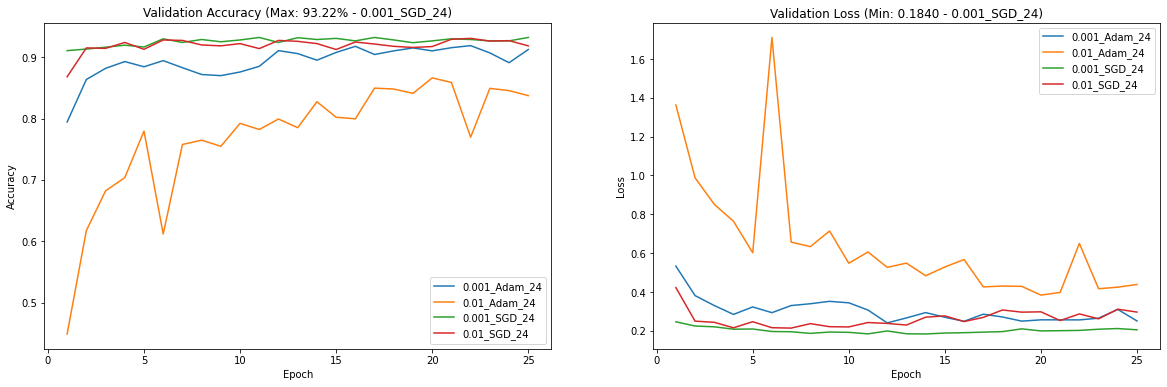

In [ ]:
plot_metrics()

**ResNet18 (Residual Network) model architecture**:

This particular ResNet model has been slightly modified from its original architecture, the final fully connected layer has been adapted to output 6 features instead of the standard 1000 for ImageNet classification.

____________________________________________________________________________



**conv1:** A 2D convolutional layer with 3 input channels, 64 output channels, a kernel size of 7x7, a stride of 2, and padding of 3.

**bn1:** A batch normalization layer for the 64 output channels of the previous layer, with an epsilon value of 1e-05 and momentum of 0.1.

**relu:** A ReLU activation function applied in-place.

**maxpool:** A 2D max-pooling layer with a kernel size of 3, a stride of 2, and padding of 1.

**layer1 to layer4:** Four sequential layers, each containing two BasicBlock modules. Each BasicBlock consists of two convolutional layers with BatchNorm2d and ReLU activation functions, and optionally a downsample layer to adjust the input shape when required.

**layer1:** Two BasicBlocks with 64 input and output channels.

**layer2:** Two BasicBlocks with 128 output channels, and downsample from 64 to 128 channels.

**layer3:** Two BasicBlocks with 256 output channels, and downsample from 128 to 256 channels.

**layer4:** Two BasicBlocks with 512 output channels, and downsample from 256 to 512 channels.

**avgpool:** An adaptive average pooling layer that reduces the spatial dimensions to 1x1.

**fc:** A fully connected (linear) layer that takes 512 input features and outputs 6 features, corresponding to the number of classes in the classification task.

In [14]:
# Testing the best model
from tqdm.auto import tqdm

# Load the saved model
model_path = os.path.join(mount_point, project_folder, 'best_model.pth')
class_names = list(dataset_paths.keys())

# Create the model architecture
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()
model = model.to(device)

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels, paths in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())#.numpy())
    image_names.extend(paths)

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data).item() / len(labels), refresh=True)

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

#softmax_scores = np.concatenate(softmax_scores)
softmax_scores = torch.cat(softmax_scores)
image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_names]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Testing progress:   0%|          | 0/24 [00:00<?, ?it/s]

                           Test accuracy: 96.73%


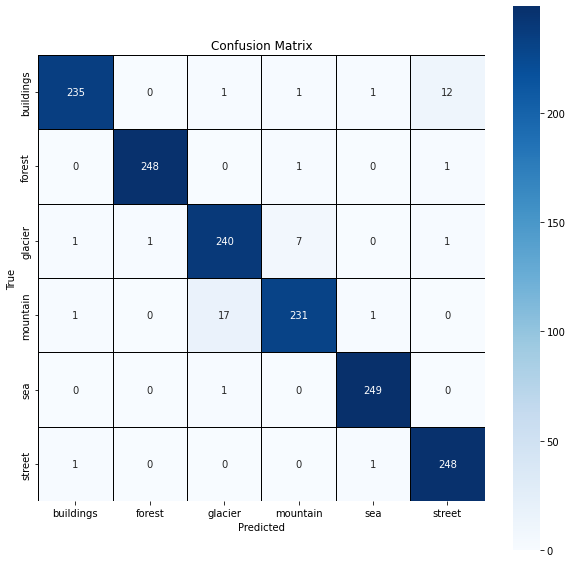

Classification Report:

              precision    recall  f1-score   support

   buildings       0.99      0.94      0.96       250
      forest       1.00      0.99      0.99       250
     glacier       0.93      0.96      0.94       250
    mountain       0.96      0.92      0.94       250
         sea       0.99      1.00      0.99       250
      street       0.95      0.99      0.97       250

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [15]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

#print(f'Softmax scores:\n\n {softmax_scores}\n\n')

for i, class_name in enumerate(class_names):
    # Get the softmax scores and image names for the current class
    mask = all_labels == i
    class_softmax_scores = softmax_scores[mask]
    class_image_names = np.array(image_names)[mask]

    # If there are no data points for the current class, skip plotting
    if len(class_softmax_scores) == 0:
        continue

    # Create a DataFrame for the softmax scores and image names
    df = pd.DataFrame(class_softmax_scores, columns=class_names)
    df['image'] = class_image_names

    # Plot the heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, cmap='Blues', square=True, linewidths=0.5, linecolor='black')
    plt.title(f'Softmax Scores for Class "{class_name}"')
    plt.xlabel('Class')
    plt.ylabel('Image')
    plt.show()

In [16]:
softmax_scores

tensor([[1.2677e-04, 6.1474e-03, 1.3926e-03, 9.9227e-01, 4.5625e-05, 1.4502e-05],
        [3.3747e-04, 9.9440e-01, 5.1782e-03, 8.0230e-07, 2.5734e-05, 6.1893e-05],
        [1.4682e-06, 9.9974e-01, 2.5627e-04, 1.3607e-07, 5.2376e-07, 3.0957e-06],
        ...,
        [4.6122e-05, 1.3851e-05, 9.6874e-04, 9.3550e-05, 9.9885e-01, 3.1685e-05],
        [3.6631e-04, 1.0747e-03, 9.6500e-01, 3.0067e-03, 3.0245e-02, 3.1223e-04],
        [2.0704e-03, 5.2982e-06, 3.9158e-06, 2.9958e-07, 1.1883e-06, 9.9792e-01]])

In [29]:
# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')

if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)

# Saving softmax scores (comment when running to compare with existing ones)
softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')
image_labels_path = os.path.join(mount_point, project_folder, softmax_folder, 'image_labels.npy')

if not os.path.exists(softmax_scores_path):
    np.save(softmax_scores_path, softmax_scores)
    print(f'\nSoftmax scores saved to {softmax_scores_path}')
else: 
    print(f'\nSoftmax scores already stored in {softmax_scores_path}')

if not os.path.exists(image_labels_path):
    np.save(image_labels_path, np.array(image_names))
    print(f'\nImage labels saved to {image_labels_path}')
else: 
    print(f'\nImage labels already stored in {image_labels_path}')


Softmax scores saved to /content/drive/My Drive/IN4310/softmax/softmax_scores.npy

Image labels saved to /content/drive/My Drive/IN4310/softmax/image_labels.npy


In [30]:
# Load saved softmax scores for comparison
if os.path.exists(os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')):
    saved_scores = np.load(os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy'))
    saved_scores = saved_scores.astype(np.float32) # convert to float32
else:
    saved_scores = np.zeros_like(softmax_scores)

if os.path.exists(os.path.join(mount_point, project_folder, softmax_folder, 'image_labels.npy')):
    saved_labels = np.load(os.path.join(mount_point, project_folder, softmax_folder, 'image_labels.npy'))
    saved_labels = saved_labels.astype(str) # convert to string
else:
    saved_labels = np.zeros_like(np.array(image_names))

# Compare the computed scores against the saved ones
if np.allclose(softmax_scores, saved_scores): 
    print('\nThe computed and the saved softmax scores Match')
else:
    print('\nThe computed and the saved softmax scores Do not match :(\n')

# Compare the computed image labels against the saved ones
if np.array_equal(np.array(image_names).astype(str), saved_labels):
    print('\nThe computed and the saved image labels Match')
else:
    print('\nThe computed and the saved image labels Do not match :(\n')
    print('Image names',image_names)
    print('Stored image names',saved_labels)

    if saved_labels is not None:
        saved_labels = saved_labels.tolist() # convert numpy array to list
        diff = list(set(saved_labels) - set(image_names))
        print(f"\n{len(diff)} images in the saved labels but not in the computed labels:")
        print(diff)
        
        diff = list(set(image_names) - set(saved_labels))
        print(f"\n{len(diff)} images in the computed labels but not in the saved labels:")
        print(diff)


The computed and the saved softmax scores Match

The computed and the saved image labels Match


To display the top-10 ranked images and bottom-10 ranked images based on their classification scores, we can use the saved softmax scores and image names from the test set. We can then sort the images based on their classification scores and display the top and bottom images.

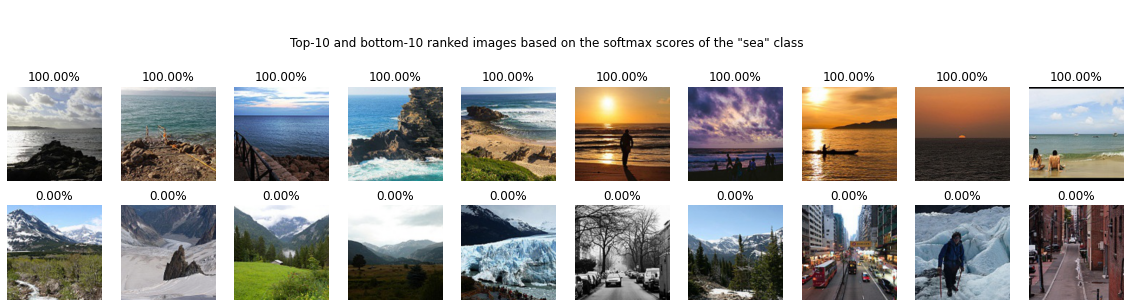

In [19]:
# Display the top-10 and bottom-10 ranked images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
fig.suptitle(f'\n\nTop-10 and bottom-10 ranked images based on the softmax scores of the "sea" class', y=1.15)

# Calculate the score for each image and sort them in ascending and descending order
scores = softmax_scores[:, class_names.index('sea')].numpy()
ascending_indices = np.argsort(scores)
descending_indices = ascending_indices[::-1]

for i in range(10):
    # Top-10 ranked images
    top_image_path = os.path.join(test_data[descending_indices[i]])
    top_image = Image.open(top_image_path)
    top_image = data_transforms['visualization'](top_image)
    top_image_np = np.array(top_image)
    top_image_rescaled = (top_image_np / np.max(top_image_np)) * 255
    axs[0, i].imshow(torch.Tensor(top_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
    axs[0, i].axis('off')
    axs[0, i].set_title(f'{scores[descending_indices[i]]*100:.2f}%')

    # Bottom-10 ranked images
    bottom_image_path = os.path.join(test_data[ascending_indices[i]])
    bottom_image = Image.open(bottom_image_path)
    bottom_image = data_transforms['visualization'](bottom_image)
    bottom_image_np = np.array(bottom_image)
    bottom_image_rescaled = (bottom_image_np / np.max(bottom_image_np)) * 255
    axs[1, i].imshow(torch.Tensor(bottom_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
    axs[1, i].axis('off')
    axs[1, i].set_title(f'{scores[ascending_indices[i]]*100:.2f}%')

plt.show()

Image classes:

1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

Enter the number corresponding to the desired class: 1


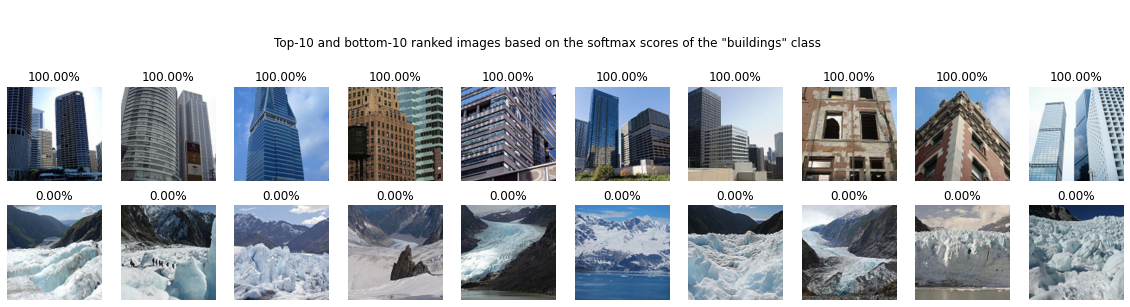

In [23]:
class_names = list(dataset_paths.keys())

# Print the numbered table of classes
print('Image classes:\n')
for i, cls in enumerate(class_names):
    print(f'{i+1}. {cls}')

# Request a choice
choice = int(input('\nEnter the number corresponding to the desired class: '))
if choice < 1 or choice > len(class_names):
    print('Invalid choice')
else:
    chosen_class = class_names[choice-1]

    # Calculate the score for each image and sort them in ascending and descending order
    scores = softmax_scores[:, class_names.index(chosen_class)].numpy()
    ascending_indices = np.argsort(scores)
    descending_indices = ascending_indices[::-1]

    # Display the top-10 and bottom-10 ranked images
    fig, axs = plt.subplots(2, 10, figsize=(20, 4))
    fig.suptitle(f'\n\nTop-10 and bottom-10 ranked images based on the softmax scores of the "{chosen_class}" class', y=1.15)

    for i in range(10):
        # Top-10 ranked images
        top_image_path = os.path.join(test_data[descending_indices[i]])
        top_image = Image.open(top_image_path)
        top_image = data_transforms['visualization'](top_image)
        top_image_np = np.array(top_image)
        top_image_rescaled = (top_image_np / np.max(top_image_np)) * 255
        axs[0, i].imshow(torch.Tensor(top_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
        axs[0, i].axis('off')
        axs[0, i].set_title(f'{scores[descending_indices[i]]*100:.2f}%')

        # Bottom-10 ranked images
        bottom_image_path = os.path.join(test_data[ascending_indices[i]])
        bottom_image = Image.open(bottom_image_path)
        bottom_image = data_transforms['visualization'](bottom_image)
        bottom_image_np = np.array(bottom_image)
        bottom_image_rescaled = (bottom_image_np / np.max(bottom_image_np)) * 255
        axs[1, i].imshow(torch.Tensor(bottom_image_rescaled).permute(1, 2, 0).numpy().astype(np.uint8))
        axs[1, i].axis('off')
        axs[1, i].set_title(f'{scores[ascending_indices[i]]*100:.2f}%')

    plt.show()

#### **Task 2:** Internals of network feature map statistics

Choose 5 feature maps as outputs of modules.

`for nam, mod in model.named_modules()`: allows you to iterate through all modules of a network

For these 5 feature maps compute the average over 200 images of
– the percentage of non-positive values, averaged over all channels
and spatial elements of it.

100% would be equal to the total size of the feature map for one
image (batchsize= 1).

In networks with ReLU these are usually zeros. In Networks with
GELU, ELU, SELU activations they can be zero or negative.

In [31]:
def get_feature_map_statistics(model, feature_map_layers, dataloader):
    feature_maps = {}
    hooks = []
    hook_stats = {name: {'non_positive_count': 0, 'total_count': 0} for name in feature_map_layers}

    def feature_map_hook(module, input, output, key):
        feature_maps[key] = output

    def statistics_hook(module, input, output, key):
        non_positive_count = (output <= 0).sum().item()
        total_count = output.numel()
        hook_stats[key]['non_positive_count'] += non_positive_count
        hook_stats[key]['total_count'] += total_count

    for name, module in model.named_modules():
        if name in feature_map_layers:
            feature_map_fn = lambda module, input, output, key=name: feature_map_hook(module, input, output, key)
            hooks.append(module.register_forward_hook(feature_map_fn))

            statistics_fn = lambda module, input, output, key=name: statistics_hook(module, input, output, key)
            hooks.append(module.register_forward_hook(statistics_fn))

    n_images = 0
    with torch.no_grad():
        for batch_idx, (images, labels, *_) in enumerate(dataloader):
            if n_images >= 200:
                break

            model(images.to(device))
            n_images += images.size(0)

    for hook in hooks:
        hook.remove()

    non_positive_percentages = {}
    for name in feature_map_layers:
        non_positive_percentage = 100 * hook_stats[name]['non_positive_count'] / hook_stats[name]['total_count']
        non_positive_percentages[name] = non_positive_percentage

    return feature_maps, non_positive_percentages

In [32]:
# Create dataloaders for train, val, and test sets with a batch_size = 1
batch_size_ = 1

dataloader_4statistics = {
    'train': DataLoader(train_dataset, batch_size = batch_size_, shuffle = True, num_workers = num_workers),
    'valid': DataLoader(val_dataset, batch_size = batch_size_, shuffle = True, num_workers = num_workers),
    'test': DataLoader(test_dataset, batch_size = batch_size_, shuffle = False, num_workers = num_workers)
}

# Feature map layers
feature_map_layers = ['maxpool','layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

# Get a sample input image
input_image = torch.randn(1, 3, 224, 224)

#model_path = os.path.join(mount_point, project_folder, 'best_model.pth')
#model.load_state_dict(torch.load(model_path, map_location=device))
#model.eval()

feature_maps, non_positive_percentages = get_feature_map_statistics(model, feature_map_layers, dataloader_4statistics['test'])

print('Feature map layers:\n')
for name, fmap in feature_maps.items():
    print(f"{name:<8}: {fmap.shape}")

print('\nThe percentage of non-positive values for selected feature maps:\n')
for name, non_positive_percentage in non_positive_percentages.items():
    print(f"{name:<8}: {non_positive_percentage:.2f}% non-positive values")

Feature map layers:

maxpool : torch.Size([1, 64, 56, 56])
layer1  : torch.Size([1, 64, 56, 56])
layer2  : torch.Size([1, 128, 28, 28])
layer3  : torch.Size([1, 256, 14, 14])
layer4  : torch.Size([1, 512, 7, 7])
avgpool : torch.Size([1, 512, 1, 1])

The percentage of non-positive values for selected feature maps:

maxpool : 23.30% non-positive values
layer1  : 23.58% non-positive values
layer2  : 49.18% non-positive values
layer3  : 55.48% non-positive values
layer4  : 43.03% non-positive values
avgpool : 1.34% non-positive values


**Task 3:**  Internals of network feature map statistics (MSc)

In [33]:
def get_feature_maps(images, model, feature_map_layers): # to speed-up compute_top_k_eigenvalues()
    """
    Get feature maps for input images in specified layers of a model.
    Args:
        images (tensor): Input images
        model (nn.Module): The model
        feature_map_layers (list): List of layer names to extract feature maps from
    Returns:
        feature_maps (dict): Dictionary with layer names as keys and feature maps as values
    """
    feature_maps = {}
    hooks = []

    def hook_fn(module, input, output, key):
        feature_maps[key] = output.detach()

    for name, module in model.named_modules():
        if name in feature_map_layers:
            hook = module.register_forward_hook(lambda module, input, output, key=name: hook_fn(module, input, output, key))
            hooks.append(hook)

    with torch.no_grad():
        model(images)

    for hook in hooks:
        hook.remove()

    return feature_maps


def compute_top_k_eigenvalues(model, feature_map_layers, dataloader, k=1000):
    device = next(model.parameters()).device
    top_k_eigenvalues = {}

    for layer in feature_map_layers:
        top_k_eigenvalues[layer] = []

    # Iterate through the dataset
    n_images = 0
    with tqdm(total=min(len(dataloader.dataset), 200)) as pbar:
        for batch_idx, (images, labels, *_) in enumerate(dataloader):
            if n_images >= 200:
                break

            with torch.no_grad():
                feature_maps = get_feature_maps(images.to(device), model, feature_map_layers)

            # Compute the mean of the feature maps over spatial dimensions
            for name, fmap in feature_maps.items():
                mean_fmap = torch.mean(fmap, dim=(2, 3)).cpu().numpy()
                top_k_eigenvalues[name].append(mean_fmap)

            n_images += len(images)
            pbar.update(len(images))

    # Calculate the empirical covariance matrix and obtain the top-k eigenvalues
    for name in feature_map_layers:
        data = np.concatenate(top_k_eigenvalues[name], axis=0)
        cov_matrix = np.cov(data, rowvar=False)
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        top_k_eigenvalues[name] = np.sort(eigenvalues)[-k:]

    # Plot the sorted top-k eigenvalues
    fig, ax = plt.subplots(figsize=(10, 6))
    for name, eigenvalues in top_k_eigenvalues.items():
        ax.plot(np.flip(eigenvalues), label=name)
    ax.set_title('Top-k Eigenvalues of Empirical Covariance Matrix')
    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Eigenvalue')
    ax.legend()
    ax.set_xlim(0, 200)
    ax.set_ylim(0, 0.05)
    plt.show()    

In [34]:
init_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = init_model.fc.in_features
init_model.fc = nn.Linear(num_features, len(class_names))

cifar10_dataset = datasets.CIFAR10(root = dst_folder, train=False, download=True, transform=data_transforms['test'])
cifar10_subset = torch.utils.data.Subset(cifar10_dataset, range(200))
dataloader_cifar = torch.utils.data.DataLoader(cifar10_subset, batch_size=1, shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data


  0%|          | 0/200 [00:00<?, ?it/s]

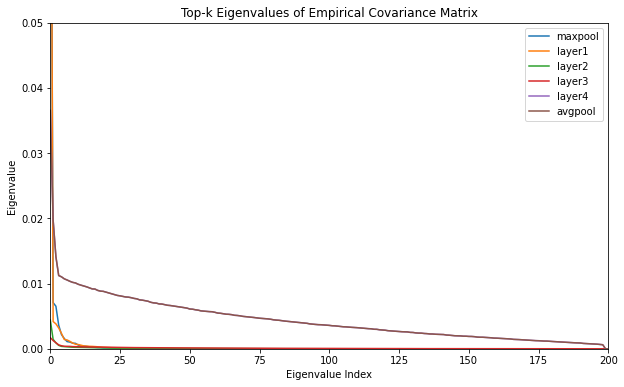

  0%|          | 0/200 [00:00<?, ?it/s]

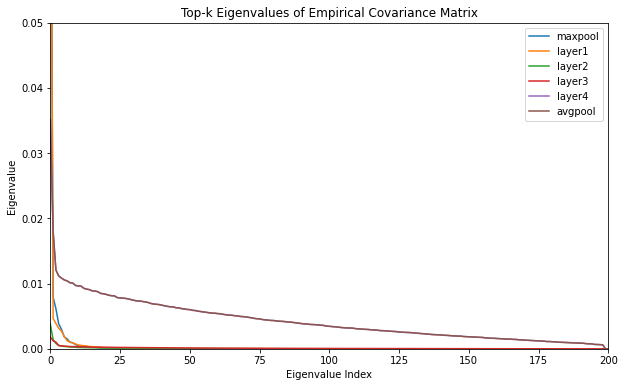

  0%|          | 0/200 [00:00<?, ?it/s]

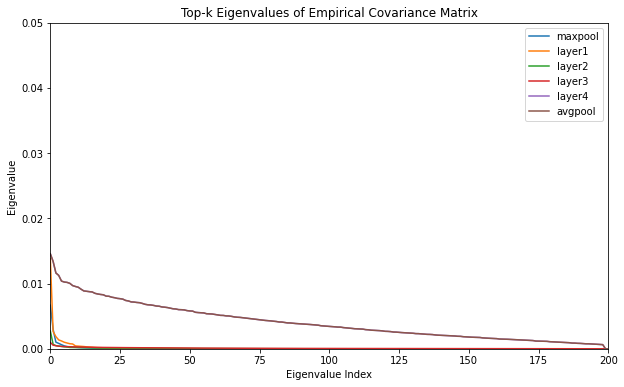

  0%|          | 0/200 [00:00<?, ?it/s]

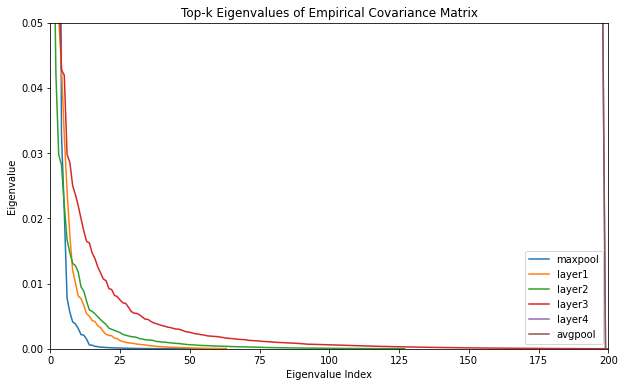

In [35]:
compute_top_k_eigenvalues(init_model, feature_map_layers, dataloader_4statistics['test'], k=1000)
compute_top_k_eigenvalues(init_model, feature_map_layers, dataloader_4statistics['valid'], k=1000)
compute_top_k_eigenvalues(init_model, feature_map_layers, dataloader_cifar, k=1000)
compute_top_k_eigenvalues(model, feature_map_layers, dataloader_4statistics['test'], k=1000)